#TP2 : Implémentation des heuristiques
### Equipe :
Aiboud Katia (CE)

Meguellati LynaRazane

Mechitoua  Ikram

Kherroubi Ilhem

Bouyousfi Rihab

Filali  Sara

In [ ]:
 pip install tsplib95


In [ ]:
 pip install tabulate


In [ ]:
# distance matrix calcultor
import tsplib95
import numpy as np
import time

def lire_fichier_tsp(nom_fichier):
    coordinates = []
    with open(nom_fichier, 'r') as fichier:
        for ligne in fichier:
            parts = ligne.split()
            if len(parts) == 3:  # Supposons que le fichier contient une ligne par ville, avec l'ID de la ville et ses coordonnées x, y
                try:
                    coordinates.append((float(parts[1]), float(parts[2])))
                except ValueError:
                    pass  # Ignore les lignes qui ne sont pas des coordonnées valides
    return coordinates

def compute_distance_matrix(coordinates):
    n = len(coordinates)
    distance_matrix = np.full((n, n), np.inf)

    for i in range(n):
        for j in range(i + 1, n):
            x1, y1 = coordinates[i]
            x2, y2 = coordinates[j]

            # Euclidean distance
            distance = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

            # we take d numbers in decimal part
            distance_matrix[i][j] = round(distance, 2)
            distance_matrix[j][i] = round(distance, 2)

    return distance_matrix



In [ ]:
'''pour le deuxieme type de fichier'''
import numpy as np

def read_tsp_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    dimension = 0
    edge_weight_section_found = False
    for line in lines:
        if line.startswith("DIMENSION"):
            dimension = int(line.split(":")[1])
        elif "EDGE_WEIGHT_SECTION" in line:
            edge_weight_section_found = True
            break

    if not edge_weight_section_found:
        raise ValueError("No EDGE_WEIGHT_SECTION found in the file.")

    matrix = np.zeros((dimension, dimension), dtype=int)

    # Find the line number where the matrix starts
    matrix_start_line = lines.index(line) + 1

    # Start reading the matrix values
    for i in range(dimension):
        values = lines[matrix_start_line + i].split()
        for j in range(dimension):
            matrix[i][j] = int(values[j])

    return matrix




# Algorithme 2-opt

L’idée de l’heuristique 2-opt est de supprimer deux arêtes du chemin initial
et de les remplacer par deux autres arêtes pour obtenir un nouveau chemin
potentiel. En inversant l’ordre des sommets situés entre les deux paires d’arêtes,
on peut explorer différentes configurations du chemin. Si le nouveau chemin a
une longueur totale inférieure à celle du chemin actuel, il est mis à jour.
Voici le principe de l’heuristique 2-opt :
1. Initialisation : Démarrez avec un chemin initial qui peut être généré de manière aléatoire ou en utilisant une heuristique de construction.
2. Boucle 2-opt : Répétez les étapes suivantes jusqu’à ce qu’aucun échange d’arête ne puisse améliorer davantage la solution :
  • Sélectionnez deux arêtes du chemin actuel (sous forme de deux paires
  de sommets consécutifs).
  • Calculez la longueur totale du chemin actuel.
  • Inversez l’ordre des sommets situés entre les deux paires d’arêtes sélectionnées, créant ainsi un nouveau chemin potentiel.
  • Calculez la longueur totale du nouveau chemin.
  • Si la longueur du nouveau chemin est inférieure à celle du chemin actuel,remplacez le chemin actuel par le nouveau chemin.
3. L’algorithme se termine lorsque la boucle 2-opt ne peut plus trouver d’échanges d’arêtes qui améliorent la solution.

In [ ]:

import math
import numpy as np
import time

def OPT(cities: np.ndarray):

    # Choisir une ville de départ aléatoire
    start_city = 0
    current_city = start_city
    tour = [start_city]
    # Initialiser le coût total à 0
    total_cost = 0
    # Tant qu'il y a des villes non visitées
    while len(tour) < np.shape(cities)[0]:

        # Trouver la ville la plus proche
        closest_city = None
        closest_distance = math.inf
        for city in range(np.shape(cities)[0]):
            if city not in tour:
                if cities[current_city][city] < closest_distance:
                    closest_city = city
                    closest_distance = cities[current_city][city]

        # Ajouter la ville la plus proche à la tournée
        if closest_city is not None:
            tour.append(closest_city)
            total_cost += closest_distance
            current_city = closest_city

    # Appliquer l'optimisation 2-opt
    improved = True
    while improved:
        improved = False
        for i in range(len(tour) - 2):
            for j in range(i + 2, len(tour) - 1):
                new_cost = (total_cost
                            - cities[tour[i], tour[i+1]]
                            - cities[tour[j], tour[j+1]]
                            + cities[tour[i], tour[j]]
                            + cities[tour[i+1], tour[j+1]])
                if new_cost < total_cost:
                    tour[i+1:j+1] = reversed(tour[i+1:j+1])
                    total_cost = new_cost
                    improved = True

    # Revenir à la ville de départ
    tour.append(start_city)
    total_cost += cities[current_city][start_city]

    return total_cost,tour



In [ ]:
from tabulate import tabulate
tsp_files = ['ulysses16.tsp','ulysses22.tsp','st70.tsp','rd100.tsp']
table_data = []

for tsp_file_path in tsp_files:
    coordinates = lire_fichier_tsp(tsp_file_path)
    D = compute_distance_matrix(coordinates)
    start = time.time()
    cost, path = OPT(D)
    end = time.time()

    table_data.append([tsp_file_path, end - start, cost])

headers = ["Fichier TSP", "Temps d'exécution (secondes)", "Cost"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))


+---------------+--------------------------------+---------+
| Fichier TSP   |   Temps d'exécution (secondes) |    Cost |
+===============+================================+=========+
| ulysses16.tsp |                    0.000878572 |   83.59 |
+---------------+--------------------------------+---------+
| ulysses22.tsp |                    0.0016849   |   85.61 |
+---------------+--------------------------------+---------+
| st70.tsp      |                    0.0364256   |  751.22 |
+---------------+--------------------------------+---------+
| rd100.tsp     |                    0.0677741   | 8864.6  |
+---------------+--------------------------------+---------+


# Heuristique de Lin-Kernighan-helsgaun

L'heuristique Lin-Kernighan-Helsgaun est une méthode d'optimisation utilisée principalement pour résoudre le problème du voyageur de commerce, visant à trouver le parcours le plus court reliant un ensemble de villes. Développée par trois chercheurs, Lin, Kernighan et Helsgaun, cette méthode combine des idées de plusieurs algorithmes précédents pour obtenir des solutions de haute qualité de manière efficace. Elle se distingue par son approche de recherche locale et sa capacité à améliorer progressivement une solution initiale en utilisant des techniques de réarrangement subtiles. L'heuristique Lin-Kernighan-Helsgaun a été largement étudiée et adaptée pour diverses applications nécessitant une optimisation de trajets ou de circuits. Son efficacité repose sur des mécanismes d'échange de segments de parcours et de sélection de mouvements intelligents, ce qui en fait un outil précieux dans le domaine de la logistique et de la planification d'itinéraires.

In [ ]:
import numpy as np

def calculate_tour_length(tour, distance_matrix):
    length = 0
    for i in range(len(tour) - 1):
        length += distance_matrix[tour[i]][tour[i+1]]
    length += distance_matrix[tour[-1]][tour[0]]  # Return to the starting city
    return length

def reverse_segment(tour, i, j):
    # Reverse the segment between indices i and j in the tour
    new_tour = tour[:i] + tour[i:j+1][::-1] + tour[j+1:]
    return new_tour

def greedy_initial_solution(distance_matrix):
    num_cities = len(distance_matrix)
    unvisited_cities = set(range(1, num_cities))
    tour = [0]  # Start from city 0

    while unvisited_cities:
        current_city = tour[-1]
        nearest_city = min(unvisited_cities, key=lambda city: distance_matrix[current_city][city])
        tour.append(nearest_city)
        unvisited_cities.remove(nearest_city)

    return tour

def lin_kernighan_helsgaun(distance_matrix):
    num_cities = len(distance_matrix)
    initial_tour = greedy_initial_solution(distance_matrix)
    # Iterative improvement
    for _ in range(20):#chosen number of iterations not necessary num_cities
        min_delta = float('inf')
        best_i, best_j = -1, -1

        for i in range(num_cities - 1):
            for j in range(i + 2, num_cities - 1):
                delta = calculate_tour_length(reverse_segment(initial_tour, i, j), distance_matrix) - calculate_tour_length(initial_tour, distance_matrix)

                if delta < min_delta:
                    min_delta = delta
                    best_i, best_j = i, j

        if min_delta < 0:
            initial_tour = reverse_segment(initial_tour, best_i, best_j)

    return initial_tour, calculate_tour_length(initial_tour, distance_matrix)

def extract_submatrix(matrix, start_row, start_col, k):
    return matrix[start_row:start_row + k, start_col:start_col + k]




In [ ]:
import time
from tabulate import tabulate
tsp_files = ['burma14.tsp','ulysses16.tsp', 'ulysses22.tsp','bayg29.tsp','st70.tsp']

# Définir manuellement les solutions exactes pour chaque jeu de données TSP

table_data = []

for tsp_file_path in tsp_files:
    coordinates = lire_fichier_tsp(tsp_file_path)
    D = compute_distance_matrix(coordinates)
    start = time.time()
    path, cost = lin_kernighan_helsgaun(D)
    end = time.time()
    execution_time = end - start
    table_data.append([tsp_file_path, cost, execution_time])

headers = ["Fichier TSP", "Coût approché obtenu", "Temps d'exécution (secondes)"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))

+---------------+------------------------+--------------------------------+
| Fichier TSP   |   Coût approché obtenu |   Temps d'exécution (secondes) |
+===============+========================+================================+
| burma14.tsp   |                  32.7  |                      0.0363927 |
+---------------+------------------------+--------------------------------+
| ulysses16.tsp |                  74.3  |                      0.0565853 |
+---------------+------------------------+--------------------------------+
| ulysses22.tsp |                  76.21 |                      0.194263  |
+---------------+------------------------+--------------------------------+
| bayg29.tsp    |               10322.5  |                      0.450024  |
+---------------+------------------------+--------------------------------+
| st70.tsp      |                 700.26 |                      3.18517   |
+---------------+------------------------+--------------------------------+





# RNN :Repetitive Nearest Neighbor


In [ ]:
def NN_ALG(G, current):
    """L'algorithme du plus proche voisin.

    G est un graphe complet non orienté sous forme de matrice d'adjacence.
    La variable current représente le sommet initial.
    """

    # Liste bestPath contient le chemin solution;
    bestPath = [0 for n in range(len(G))]
    # Liste visited contient les sommets déjà visités;
    visited = [current]

    # Trouve la plus courte parmi les arêtes
    # connectant le sommet actuel
    # avec les sommets non visités.
    for i in range(len(G)):
        # Le tuple minimum := (w, j) contient l'indice du sommet non visité
        # j et le poids de l'arête w, reliant j au dernier sommet ajouté
        # à la solution.
        minimum = (0, 0)
        for j in range(len(G)):
            if (j not in visited and
                (0 < G[current][j] < minimum[0] or minimum == (0, 0))):
                minimum = (G[current][j], j)

        current = minimum[1]
        bestPath[i] = visited[-1]
        visited.append(current)

    # Le chemin est connecté pour former un cycle
    bestPath.append(bestPath[0])

    # Calcul du poids du chemin
    path_weight = 0
    for i in range(len(bestPath) - 1):
        path_weight += G[bestPath[i]][bestPath[i+1]]

    return bestPath, path_weight


def RNN_ALG(G):
    """Powtarzalny algorytm najbliższego sąsiada (RNN).
    G jest pełnym grafem nieskierowanym w postaci macierzy sąsiedztwa.
    """

    # Lista bestPath zawiera ścieżkę o najmniejszej wadze z już sprawdzonych ścieżek.
    bestPath = None
    bestPathWeight = 0

    for i in range(len(G)):
        # Wywoływany jest algorytm najbliższego sąsiada dla każdego n.
        temp_path, temp_weight = NN_ALG(G, i)

        # Porównywana jest obecna najlepsza ścieżka z nowym rozwiązaniem.
        if temp_weight < bestPathWeight or bestPathWeight == 0:
            bestPathWeight = temp_weight
            bestPath = temp_path

    return bestPath, bestPathWeight

In [ ]:
import time
from tabulate import tabulate

tsp_files = ['burma14.tsp','ulysses16.tsp', 'ulysses22.tsp','bayg29.tsp','st70.tsp']

# Définir manuellement les solutions exactes pour chaque jeu de données TSP

table_data = []

for tsp_file_path in tsp_files :
    coordinates = lire_fichier_tsp(tsp_file_path)
    D = compute_distance_matrix(coordinates)
    start = time.time()
    path,cost = RNN_ALG(D)
    end = time.time()
    execution_time = end - start
    table_data.append([tsp_file_path, cost, execution_time])

headers = ["Fichier TSP", "Coût approché obtenu", "Temps d'exécution (secondes)"]

print(tabulate(table_data, headers=headers, tablefmt="grid"))

+---------------+------------------------+--------------------------------+
| Fichier TSP   |   Coût approché obtenu |   Temps d'exécution (secondes) |
+===============+========================+================================+
| burma14.tsp   |                  31.21 |                     0.00425982 |
+---------------+------------------------+--------------------------------+
| ulysses16.tsp |                  77.12 |                     0.00186539 |
+---------------+------------------------+--------------------------------+
| ulysses22.tsp |                  86.9  |                     0.00429773 |
+---------------+------------------------+--------------------------------+
| bayg29.tsp    |               10778.4  |                     0.0117161  |
+---------------+------------------------+--------------------------------+
| st70.tsp      |                 761.66 |                     0.190882   |
+---------------+------------------------+--------------------------------+


In [ ]:
import time
from tabulate import tabulate

tsp_files = ['burma14.tsp','ulysses16.tsp', 'ulysses22.tsp','bayg29.tsp','st70.tsp']

table_data = []

for tsp_file_path in tsp_files:
    coordinates = lire_fichier_tsp(tsp_file_path)
    D = compute_distance_matrix(coordinates)

    start = time.time()
    cost1, path1 = OPT(D)
    end = time.time()
    execution_time1 = end - start

    start = time.time()
    path2, cost2 = lin_kernighan_helsgaun(D)
    end = time.time()
    execution_time2 = end - start

    start = time.time()
    path3, cost3 = RNN_ALG(D)
    end = time.time()
    execution_time3 = end - start

    table_data.append([tsp_file_path,
                       execution_time1, cost1,
                       execution_time2, cost2,
                       execution_time3, cost3])

headers = ["Fichier TSP", "Temps exécution 2 OPT (s)", "Coût 2 OPT", "Temps exécution LKH (s)", "Coût LKH", "Temps exécution RNN (s)", "Coût RNN"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))


+---------------+-----------------------------+--------------+---------------------------+------------+---------------------------+------------+
| Fichier TSP   |   Temps exécution 2 OPT (s) |   Coût 2 OPT |   Temps exécution LKH (s) |   Coût LKH |   Temps exécution RNN (s) |   Coût RNN |
+===============+=============================+==============+===========================+============+===========================+============+
| burma14.tsp   |                 0.000442028 |        38.49 |                 0.0307288 |      32.7  |                0.00120473 |      31.21 |
+---------------+-----------------------------+--------------+---------------------------+------------+---------------------------+------------+
| ulysses16.tsp |                 0.000464439 |        83.59 |                 0.0260794 |      74.3  |                0.00166035 |      77.12 |
+---------------+-----------------------------+--------------+---------------------------+------------+---------------------------

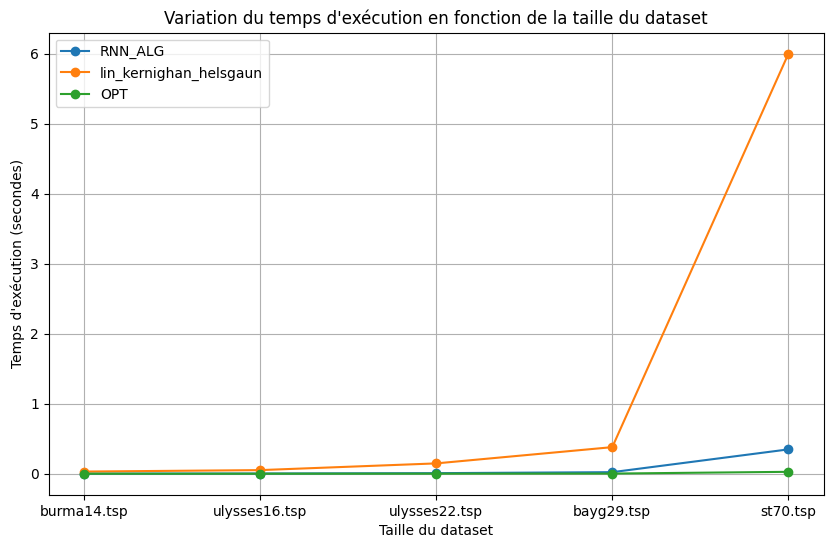

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np


# Définissez les fichiers de jeu de données
tsp_files = ['burma14.tsp','ulysses16.tsp', 'ulysses22.tsp','bayg29.tsp','st70.tsp']

# Stockez les temps d'exécution pour chaque algorithme et chaque ensemble de données
# dans un dictionnaire où la clé est le nom de l'algorithme
# et la valeur est une liste de temps d'exécution correspondants pour chaque ensemble de données
execution_times = {'RNN_ALG': [], 'lin_kernighan_helsgaun': [], 'OPT': []}

# Choisissez l'algorithme de lecture de fichier de données
def read_dataset(filename):
    try:
        return compute_distance_matrix(lire_fichier_tsp(filename))
    except ValueError:
        return read_tsp_file(filename)

# Boucle sur les fichiers de jeu de données
for tsp_file in tsp_files:
    # Lire le jeu de données
    dataset = read_dataset(tsp_file)
    # Boucle sur les algorithmes
    for algo_name, algo_func in [('RNN_ALG', RNN_ALG), ('lin_kernighan_helsgaun', lin_kernighan_helsgaun), ('OPT',OPT)]:
        start_time = time.time()
        # Exécutez l'algorithme sur le jeu de données actuel
        algo_func(dataset)
        end_time = time.time()

        # Enregistrez le temps d'exécution
        execution_times[algo_name].append(end_time - start_time)

# Tracez les graphiques
plt.figure(figsize=(10, 6))
for algo_name, times in execution_times.items():
    plt.plot(range(1, len(tsp_files) + 1), times, marker='o', label=algo_name)

plt.xticks(range(1, len(tsp_files) + 1), tsp_files)
plt.xlabel('Taille du dataset')
plt.ylabel('Temps d\'exécution (secondes)')
plt.title('Variation du temps d\'exécution en fonction de la taille du dataset')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import time
from tabulate import tabulate

tsp_files = ['burma14.tsp','ulysses16.tsp', 'ulysses22.tsp','bayg29.tsp','st70.tsp']
exact_solutions = [30.87,73.98, 75.29, 10000,  675]
#pour bayg29 on a aps trouver la solution exacte
table_data = []

for tsp_file_path, exact_solution in zip(tsp_files, exact_solutions):
    coordinates = lire_fichier_tsp(tsp_file_path)
    D = compute_distance_matrix(coordinates)

    start = time.time()
    cost1, path1 = OPT(D)
    end = time.time()
    execution_time1 = end - start

    start = time.time()
    path2, cost2 = lin_kernighan_helsgaun(D)
    end = time.time()
    execution_time2 = end - start

    start = time.time()
    path3, cost3 = RNN_ALG(D)
    end = time.time()
    execution_time3 = end - start

    table_data.append([tsp_file_path,
                       exact_solution,
                       execution_time1, cost1,
                       execution_time2, cost2,
                       execution_time3, cost3,
                       ])

headers = ["Fichier TSP",  "Solution exacte","Temps exécution 2 OPT (s)", "Coût 2 OPT", "Temps exécution LKH (s)", "Coût LKH", "Temps exécution RNN (s)", "Coût RNN", "Solution exacte"]
print(tabulate(table_data, headers=headers, tablefmt="grid"))


+---------------+-------------------+-----------------------------+--------------+---------------------------+------------+---------------------------+------------+
| Fichier TSP   |   Solution exacte |   Temps exécution 2 OPT (s) |   Coût 2 OPT |   Temps exécution LKH (s) |   Coût LKH |   Temps exécution RNN (s) |   Coût RNN |
+===============+===================+=============================+==============+===========================+============+===========================+============+
| burma14.tsp   |             30.87 |                 0.000389814 |        38.49 |                 0.0391283 |      32.7  |                0.00205564 |      31.21 |
+---------------+-------------------+-----------------------------+--------------+---------------------------+------------+---------------------------+------------+
| ulysses16.tsp |             73.98 |                 0.000890255 |        83.59 |                 0.115981  |      74.3  |                0.0133121  |      77.12 |
+---------